# Prerequisites

In [ ]:
!pip install -q -U progressbar2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import  Model
import os
from math import log2
import time
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from IPython.display import clear_output
import shutil
import progressbar

matplotlib.use('Agg')
plt.ioff()

In [ ]:
#buffer size of the input pipeline
BUFFER_SIZE = 50000
#batch size
BATCH_SIZE= 16
#number of epochs
EPOCHS = 30
#number of epochs when the pre training.
PRETRAIN_EPOCHS = 50
#image size
IMG_SIZE = 128
#number of output channel(in this case 2)
OUTPUT_CHANNELS = 2
#lambda value of the generator function
LAMBDA = 0.005
#folder containing the datasets.
BASE_PATH = '/content/drive/My Drive/Bw2Color'

Download the training/val dataset from the google drive

In [ ]:
#mount the drive.
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
#download the the training set.
shutil.copy(f'{BASE_PATH}/Train.zip', ".")
!unzip -q Train.zip
!rm Train.zip

In [ ]:
#download the the validation set.
shutil.copy(f'{BASE_PATH}/Val.zip', ".")
!unzip -q Val.zip
!rm Val.zip

# Data preprocessing

Here we define the necessary functions for the online preprocessing steps.

In [ ]:
"""
Convert a bath of images from the RGB space to LAB space
(Code adapted from:https://github.com/xahidbuffon/TF_RGB_LAB/blob/master/rgb_lab_formulation.py).
"""
def convert2lab(img):
  srgb_pixels = tf.reshape(img, [-1, 3])
  
  linear_mask = tf.cast(srgb_pixels <= 0.04045, dtype=tf.float32)
  exponential_mask = tf.cast(srgb_pixels > 0.04045, dtype=tf.float32)
  rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask
  rgb_to_xyz = tf.constant([
      #    X        Y          Z
      [0.412453, 0.212671, 0.019334], # R
      [0.357580, 0.715160, 0.119193], # G
      [0.180423, 0.072169, 0.950227], # B
  ])
  xyz_pixels = tf.matmul(rgb_pixels, rgb_to_xyz)
 
# https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
  xyz_normalized_pixels = tf.multiply(xyz_pixels, [1/0.950456, 1.0, 1/1.088754])
 
  epsilon = 6/29
  linear_mask = tf.cast(xyz_normalized_pixels <= (epsilon**3), dtype=tf.float32)
  exponential_mask = tf.cast(xyz_normalized_pixels > (epsilon**3), dtype=tf.float32)
  fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4/29) * linear_mask + (xyz_normalized_pixels ** (1/3)) * exponential_mask
 
  # convert to lab
  fxfyfz_to_lab = tf.constant([
      #  l       a       b
      [  0.0,  500.0,    0.0], # fx
      [116.0, -500.0,  200.0], # fy
      [  0.0,    0.0, -200.0], # fz
  ])
  lab_pixels = tf.matmul(fxfyfz_pixels, fxfyfz_to_lab) + tf.constant([-16.0, 0.0, 0.0])
 
  return tf.reshape(lab_pixels, tf.shape(img))

"""
Convert a bath of images from the LAB space to  space
(Code adapted from:https://github.com/xahidbuffon/TF_RGB_LAB/blob/master/rgb_lab_formulation.py).
"""

def convert2rgb(lab):
  lab_pixels = tf.reshape(lab, [-1, 3])
# https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
  # convert to fxfyfz
  lab_to_fxfyfz = tf.constant([
      #   fx      fy        fz
      [1/116.0, 1/116.0,  1/116.0], # l
      [1/500.0,     0.0,      0.0], # a
      [    0.0,     0.0, -1/200.0], # b
  ])
  fxfyfz_pixels = tf.matmul(lab_pixels + tf.constant([16.0, 0.0, 0.0]), lab_to_fxfyfz)

  # convert to xyz
  epsilon = 6/29
  linear_mask = tf.cast(fxfyfz_pixels <= epsilon, dtype=tf.float32)
  exponential_mask = tf.cast(fxfyfz_pixels > epsilon, dtype=tf.float32)
  xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4/29)) * linear_mask + (fxfyfz_pixels ** 3) * exponential_mask

    # denormalize for D65 white point
  xyz_pixels = tf.multiply(xyz_pixels, [0.950456, 1.0, 1.088754])

      
  xyz_to_rgb = tf.constant([
      #     r           g          b
      [ 3.2404542, -0.9692660,  0.0556434], # x
      [-1.5371385,  1.8760108, -0.2040259], # y
      [-0.4985314,  0.0415560,  1.0572252], # z
  ])
  rgb_pixels = tf.matmul(xyz_pixels, xyz_to_rgb)
  # avoid a slightly negative number messing up the conversion
  rgb_pixels = tf.clip_by_value(rgb_pixels, 0.0, 1.0)
  linear_mask = tf.cast(rgb_pixels <= 0.0031308, dtype=tf.float32)
  exponential_mask = tf.cast(rgb_pixels > 0.0031308, dtype=tf.float32)
  srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + ((rgb_pixels ** (1/2.4) * 1.055) - 0.055) * exponential_mask

  return tf.reshape(srgb_pixels, tf.shape(lab))


In [ ]:
"""
Resize an image so that the shortest side is of the given size while maintaing the
aspect-ration.
"""
def resize_with_ratio(img, size):
  #retrieve the size of the image.
  w, h = tf.shape(img)[0], tf.shape(img)[1]
 
  #calculate the new size.
  new_height = h * size // tf.minimum(w, h)
  new_width = w * size // tf.minimum(w, h)
  
  #reize the image.
  img = tf.image.resize(img, [new_width, new_height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return img
 

"""
Extract a square patch of the given size from the center of the image.
"""
def center_crop(img, size):
  #retrieve the size of the image.
  w, h = tf.shape(img)[0], tf.shape(img)[1]

  #calculate the left-uppermost coordinates of the pacth being extraxted.
  x = (w - IMG_SIZE)//2
  y = (h - IMG_SIZE)//2

  #crop the central patch.
  img = tf.image.crop_to_bounding_box(img, x, y, IMG_SIZE, IMG_SIZE)
  return img
 
"""
Normalize a batch images in lab space so that each pixel is in the range [-1, 1].
"""
def normalise(lab_imgs):
  #reshape the batch of images to (batch*height*width, num_channel)..
  imgs = tf.reshape(lab_imgs, [-1, 3])
  #nomarmalise the values.
  normalised = (imgs / [50.0, 110.0, 110.0] ) - [1.0, 0.0, 0.0]
  #reshape the array to the original shape.
  return tf.reshape(normalised, tf.shape(lab_imgs))

"""
Denormalise values of a batch of images in lab space to the original range.
"""
def denormalise(lab_imgs):
  #reshape the batch of images to (batch*height*width, num_channel).
  imgs = tf.reshape(lab_imgs, [-1, 3])
  #nomarmalise the values.
  unormalised = (imgs + [1.0, 0.0, 0.0]) * [50.0, 110.0, 110.0]
  #reshape the array to the original shape.
  return tf.reshape(unormalised, tf.shape(lab_imgs))

"""
Randomly flip the image on the vertical axis.
"""
def data_augmentation(img):
  img = tf.image.random_flip_left_right(img)
  return img

"""
Recontruct the RGB image given the L-channel and AB-channels.
Values are in the range [0, 1] if the rescale is Fasle, otherwise they are
rescaled to the range [0, 255].
"""
def post_process(L, AB, rescale=False):
  #concatenate the L and AB channels.
  image_lab = tf.concat([L, AB], axis=-1)
  #denormalise the values.
  image_lab = denormalise(image_lab)
  #convert the image back to the rgb space.
  img_rgb = convert2rgb(image_lab)
  #rescale the values to the range [0, 255] if required.
  if rescale:
    img_rgb = img_rgb*255.0

  return img_rgb

# Input pipeline

Here we create the input pipeline for the trainig dataset and validation dataset which will be used to generated images during the training process in order to assess the performance of the generator. 

In [ ]:
"""
Load the image.
"""
def load(image_path):
  #read the content of the file.
  img = tf.io.read_file(image_path)
  #decode the content of the file as jpeg image.
  img = tf.image.decode_jpeg(img, channels=3)
  #scale the values so that the fall in the range [0, 1].
  img = tf.cast(img, dtype=tf.float32)/255.0
  return img
 
"""
Load an image and apply the preprocess step.
Return a tuple made of the luminance channel L, the chromatic channels AB
and the path of the image.
"""
def load_image_train(file_path):
  #load the image.
  img = load(file_path)
  #apply data augmentation
  img = tf.image.random_flip_left_right(img)
  #convert to lab space.
  lab_img = convert2lab(img)
  #normalise the values.
  lab_img = normalise(lab_img)
  #extract the luminance channel.
  L = lab_img[:,:,0][..., tf.newaxis]
  #extract the chromatic channels
  AB = tf.stack([lab_img[:,:,1], lab_img[:,:,2]], axis=-1)

  return L, AB, file_path
 
"""
Load an image and apply the preprocess step without the data augmentation.
Return a tuple made of the luminance channel L and the path of the image.
 """

#load an image and cretes the couple (L, RGB)
def load_image_test(file_path):
  #load image as RGB.
  img = load(file_path)
  #Convert the image to LAB Space.
  lab_img = convert2lab(img)
  #Nomalise the values so that they are in the range [-1, -1]
  lab_img = normalise(lab_img)
  #Extract the L channel.
  L = lab_img[:,:,0][..., tf.newaxis]
  return L, img, file_path

AUTOTUNE = tf.data.experimental.AUTOTUNE

#create the training dataset pipeline.
train_dataset = tf.data.Dataset.list_files('/content/Train/*.jpg')
                                              
train_dataset = train_dataset.shuffle(BUFFER_SIZE)\
                            .map(load_image_train, num_parallel_calls=AUTOTUNE)\
                            .batch(BATCH_SIZE)\
                            .prefetch(AUTOTUNE)

#create the validation dataset pipeline.
val_dataset = tf.data.Dataset.list_files('/content/Val/*.jpg', shuffle=False)
                                              
val_dataset = val_dataset.map(load_image_test)\
                          .batch(BATCH_SIZE)\
                          .prefetch(AUTOTUNE)

# Building blocks

Here we create the building blocks that is the _Conv-BatchNorm-ReLu_ and _ResizeConv-BatchNorm-Dropout-ReLu_ modulues that compose the encoder and decoder of the generator. Each _Conv_ layer in the encoder downsample the input by a factor of two by using a 4x4 kernel, stride 2 and 'same' padding. The _ResizeConv_ layer first upsample the input by a factor of two using a simple resize operation and then apply a convolution operation parameterized by  3x3 kernel, stride 1 and 'valid' padding.

In [ ]:
"""
Implement the resize-convolution layer. Take as parameters:
- the number of filters;
- the kernel size and stride value of the convolution operation;
- the upsampling factor(default 2);
- A flag that specify if the bias are needed in the convolution layer.
"""
class Resize_Conv2D(Layer):
  def __init__(self, filters, kernel, stride, use_bias=False, upsampling_factor=2):
        self.filters = filters
        self.kernel = kernel
        self.stride = stride
        self.use_bias = use_bias
        self.upsampling_factor = upsampling_factor
        
        super(Resize_Conv2D, self).__init__()

  def build(self, input_shape):
    #initialize the weights of the convolution layer using a normal ditribution with mean 0 and
    #standard deviation 0.02.
    initializer = tf.random_normal_initializer(0., 0.02)
    #the size of the padding applied to the input.
    pad = self.kernel // 2
    self.paddings = tf.constant([[0, 0], [pad, pad],[pad, pad], [0, 0]])
    #the convolution layer
    self.conv2d = Conv2D(self.filters, self.kernel, self.stride, use_bias=self.use_bias,
                         padding='valid', kernel_initializer=initializer)
  def call(self, inputs):
      #calculate the new size of the input.
      new_h = inputs.shape[1] * self.upsampling_factor
      new_w = inputs.shape[2] * self.upsampling_factor
      #resize the input.
      x = tf.image.resize(inputs, [new_h, new_w], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
      #apply padding the avoid artifacts at the border.
      x = tf.pad(x, self.paddings, mode='REFLECT')
      #apply the convolution layer.
      x = self.conv2d(x)
      return x 

In [ ]:
"""
Define the Conv-BatchNorm-ReLu block for the encoder part of the generator.
"""
def down_sample(input, filters, apply_batchnorm=True):
  #initialize the weight with a normal distribution with mean 0 and standard deviation on 0.02.
  initializer = tf.random_normal_initializer(0., 0.02)

  #apply the convultion layer.
  x = Conv2D(filters, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(input)
  #apply the batch normalization layer if required.
  if apply_batchnorm:
    x = BatchNormalization()(x,training=True)
  #apply the leaky relu activation function.
  x = LeakyReLU(alpha=0.2)(x)

  return x

"""
Define the ResizeConv-BatchNorm-Droput-ReLu block for the  decoder part of the generator.
"""
def up_sample(input, skip, filters, apply_dropout=False):
  #initialize the weight with a normal distribution with mean 0 and standard deviation on 0.02.
  initializer = tf.random_normal_initializer(0., 0.02)

  #apply the resize-conv layer.
  x = Resize_Conv2D(filters, 3, 1)(input)
  #apply the batch normalization layer.
  x = BatchNormalization()(x,training=True)
  #apply the dropout layer if required.
  if apply_dropout:
    x = Dropout(0.5)(x, training=True)
  #apply the ReLu activation function.
  x = ReLU()(x)
  #concatenate the activations if i and n-i layers.
  x = Concatenate()([x, skip])

  return x

# Generator

The Generator has encoder-decoder architecture with skip connection between the _i_-th layer and _n-i_-th layer of the model. Each block of the encoder has the from of _Conv->Batchnorm->ReLU_ and while the decoder has blocks of the from _ResizeConv->Batchnorm->Dropout(applied to the first 2 blocks)->ReLU_. It takes in input the luminance L channel as a 128x128x1 tensor and produce the chromatic _a_ and _b_ channels as 128x128x2 tensor.

The following diagram shows the generatoe architecture.

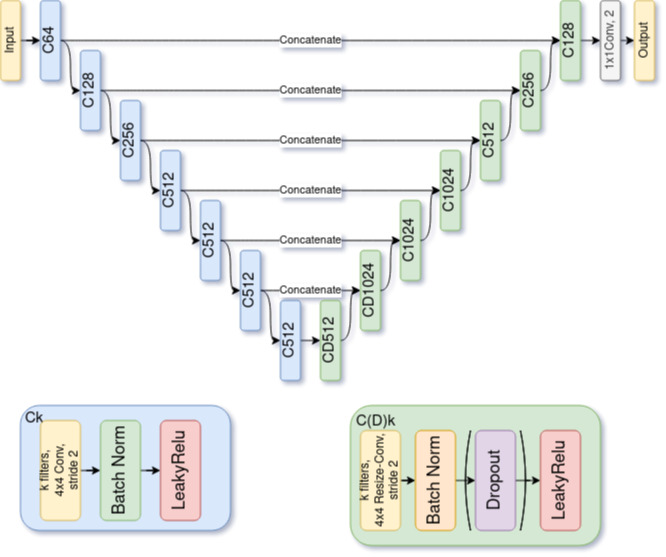

In [ ]:
"""
Define the architecture of the generator.
"""
def define_generator(input_shape, output_channel, n_blocks):
  #initialize the weight with a normal distribution with mean 0 and standard deviation on 0.02.
  initializer = tf.random_normal_initializer(0., 0.02)
  #define the input.
  inputs = Input(input_shape)

  #the number of initial filters.
  min_filters = 64
  
  #build the encoder part of the generator.
  x = down_sample(inputs, 64, apply_batchnorm=False)
  skips = [x]
  nb_filters = [min_filters]
  for i in range(1, n_blocks - 1):
    filters = min_filters * min(8, (2 ** i))
    x = down_sample(x, filters)
    skips.append(x)
    nb_filters.append(filters)
  
  #central block of the encoder-decoder 
  x = down_sample(x, 512, apply_batchnorm=False)

  #build the decoder part of the generator. 
  nb_filters = reversed(nb_filters)
  skips = reversed(skips)
  for i, (filters, skip) in enumerate(zip(nb_filters, skips)):
    apply_dp = i < 2
    x = up_sample(x, skip, filters, apply_dropout=apply_dp)

  #apply the last resize-convolution layer.
  x = Resize_Conv2D(output_channel, 3, 1, use_bias=True)(x)
  #apply the tanh convolution layer.
  output = Activation('tanh')(x)
  
  #return the model
  return Model(inputs=inputs, outputs=output)

# Discriminator

The discriminator takes in input a batch of luminance L channel as 128x128x1 tensor and the chromatic a and b channels as a 128x128x2 tensor. This two inputs are concatenated to form the input image to be classified and then applies a series of downsampling Conv->Batchnorm->ReLU modules so that the receptived field of the last convolution layer which is used for the output, has size 70x70. The discriminator output is 14x14x1 tensor where each entry is classification of a 70x70 portion of the image. Assuming the kernel size is the same in each convolution operation, the receptive field of convolution layer at level $L$ can be calulated with following recursive equation:
$$
\begin{aligned}
 r_0 &= k\\
r_{i+1} &= s_{i-1}\cdot r_{i-1} + (k + s_{i-1})
\end{aligned}  
$$
where $s_{i}$ is the number of stride of the convolution layer at level $i$. So $r_L$ is the receptive field of convolution layer at level L. 

The following diagram shows the discriminator architecture.

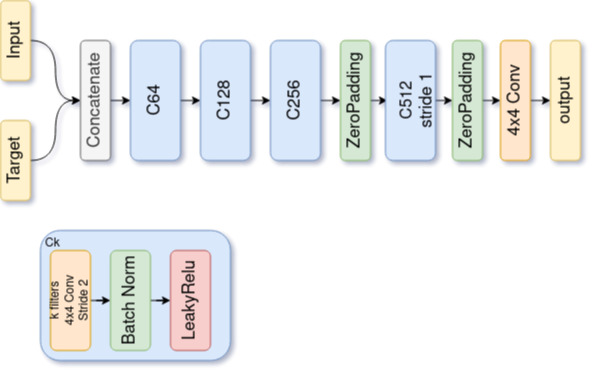

In [ ]:
"""
Define the architecture of the discriminator.
"""
def define_discriminator(input_shape, target_shape):
  #initialize the weight with a normal distribution with mean 0 and standard deviation on 0.02.
  initializer = tf.random_normal_initializer(0., 0.02)
  #define the input that containes the luminance channel.
  inp = Input(shape=input_shape, name='input_image')
  #define the input that containes the chromatic channels.
  tar = Input(shape=target_shape, name='target_image')
  #concatenate the inputs
  x = Concatenate()([inp, tar])

  #downsamples steps.
  x = down_sample(x, 64, apply_batchnorm=False)# (bs, 64, 64, 64)
  x = down_sample(x, 128) # (bs, 32, 32, 128)
  x = down_sample(x, 256) # (bs, 16, 16, 256)

  #apply zero padding so that the 
  x = ZeroPadding2D()(x) #(bs, 18, 18, 256)
  x = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)# (bs, 15, 15, 512)

  #apply batchnormalization also at inference time.
  x = BatchNormalization()(x, training=True)
  x = LeakyReLU()(x)
  x = ZeroPadding2D()(x)#(bs, 17, 17, 512)

  #generate the output.
  last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)#(bs, 14, 14, 1)
  
  #return the model.
  return Model(inputs=[inp, tar], outputs=last)

# Feature Loss

Define the feature loss used as the additional loss for the generator. This loss is defined as the sum of the mean abbsolute error between the feature representation at layers _conv1\_1_, _conv1\_2_, _conv3\_1_, _conv4\_1_, _conv5\_1_,_conv5\_2_, _conv5\_3_ and _conv5\_4_ of the real image and the colorized in a pre-trained VGG19 network.

The figure below shows where the choosen layers are in the vgg19 network.

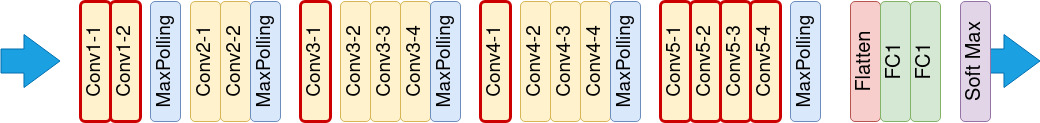


In [ ]:
"""
Define the model that outputs the activation of the choosen layers of the vgg19 network. 
"""
def feature_extractor_model(input_shape):
  #the choosen layer for the feature loss.
  feature_layers = ['block1_conv1',
                    'block1_conv2',
                    'block3_conv1',
                    'block4_conv1',
                    'block5_conv1',
                    'block5_conv2',
                    'block5_conv3',
                    'block5_conv4']

  #load the pre trained VGG19 netowrk
  vgg_model = tf.keras.applications.VGG19(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
  #freeze the weights of the model.
  vgg_model.trainable = False

  #extract the activation of the layer.
  outputs = [vgg_model.get_layer(layer).output for layer in feature_layers]
  
  #define the model.
  extractor = tf.keras.Model(vgg_model.input, outputs)
  return extractor

"""
Implement the feature loss.
"""
@tf.function
def feature_loss(feature_extractor, input_l, fake_ab, real_ab):
  #wieghts of each loss.
  feature_weights = [10, 10, 7, 7, 10, 10, 10, 10]

  #convert the generated image from lab space to rgb.
  fake_img = post_process(input_l, fake_ab, rescale=True)
  #convert the real image from lab space to rgb.
  real_img = post_process(input_l, real_ab, rescale=True)

  #preprocess the images for the vgg19 netowrk.
  fake_preprocessed = tf.keras.applications.vgg19.preprocess_input(fake_img)
  real_preprocessed = tf.keras.applications.vgg19.preprocess_input(real_img)

  #extract the feature representations
  fake_features = feature_extractor(fake_preprocessed)
  real_features = feature_extractor(real_preprocessed)

  #calculate the sum of the mean absolut error between the feature representation of the fake and
  #real image.
  loss = tf.add_n([tf.reduce_mean(tf.abs(real-fake))*w
                        for real, fake, w in zip(real_features, fake_features, feature_weights)])
  #return the calculated loss.
  return loss

# Generated samples

In [ ]:
"""
Generate a plot showing the input, the colorization produce by
generator and the image for each image in the given dataset.
"""
def generate_images(dataset, generator, save_path):
  #For each image in the dataset produce the a tuple containg the input, the image itself
  #and colorization done by the generator.
  def generate(dataset, generator):
    #create array for the inputs, the real images and the generated ones.
    fake_images = np.empty(shape=(0, IMG_SIZE, IMG_SIZE, 3))
    inputs = np.empty(shape=(0, IMG_SIZE, IMG_SIZE, 1))
    real_images = np.empty_like(fake_images)
    
    for Ls, real, _ in dataset:
      #predict the chromatic channels from the luminance channel.
      fake_ABs = generator.predict(Ls)
      #convert the generated image back to the RGB space
      fake_RGBs = post_process(Ls, fake_ABs)

      fake_images = np.append(fake_images, fake_RGBs, axis=0)
      inputs = np.append(inputs, Ls, axis=0)
      real_images = np.append(real_images, real, axis=0)

    return inputs, real_images, fake_images 

  #Generate a plot showing the input, the colorization produce by
  #generator and the image for each image in the given dataset.
  fig =  plt.figure(dpi=300, figsize=(30,30), constrained_layout=False)

  inputs, real_images, fake_images = generate(dataset, generator)
  num_images = fake_images.shape[0]

  grid = ImageGrid(fig, 141,  #
                     nrows_ncols=(num_images, 3),
                     axes_pad=0.01,
                     label_mode="1",
                     )

  title = ['Input','Real', 'Fake']

  for n, (L, real, fake) in enumerate(zip(inputs, real_images, fake_images)):
    input = (L[..., 0] + 1.0)/2.0
    images = [input , real, fake]

    for i in range(3):
      ax = grid[n*3 + i]
      ax.axis('off')
      if n == 0:
        ax.set_title(title[i])
      if i == 0:
        ax.imshow(images[i], cmap='gray', aspect='auto')
      else:
        ax.imshow(images[i], aspect='auto')
      
  fig.savefig(save_path, bbox_inches='tight', aspect='auto')

# Pretraining

Pretrain the generator using only the feature loss for 50 epochs. Given an input luminance channel $x$ and the target chromatic channels $y$, the training loop:

1. Predict the output using the generator;
2. Calculate the feature loss;
3. Calculate the gradients with respect to the  generator variables;
6. Apply the gradients to generator optimzer.



In [ ]:
#Define a summary writer for tensor board in order to monitor the
#the losses.
import datetime
log_dir="logs/"
 
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
#define the optimzer for the generator.
optimizer = tf.keras.optimizers.Adam(0.0004, beta_1=0.5)
#define the feature representation extractor.
feature_extractor = feature_extractor_model((IMG_SIZE, IMG_SIZE, 3))

In [ ]:
#define the generator.
generator = define_generator([IMG_SIZE, IMG_SIZE, 1], OUTPUT_CHANNELS, int(log2(IMG_SIZE)))

In [ ]:
#Define a checkpoint-manager in order to save the model weights during the pretraining so that after the
#training the generator that yielded the best result can be restored.
pretrianed_checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 generator=generator,
                                 current_epoch=tf.Variable(0))
pretrianed_manager = tf.train.CheckpointManager(pretrianed_checkpoint, f'{BASE_PATH}/pretrained', max_to_keep=8)

In [ ]:
"""
Pretrain the generator using only the feature loss.
"""
def pretrain_generator(train_ds, epochs):
  #define the progress bar layout.
  widgets=[
      progressbar.Bar(marker='=', left='[', right=']'),
      progressbar.widgets.SimpleProgress(),
      ' - ', progressbar.Timer(),'',
      '-', progressbar.AdaptiveETA(), ''
  ]

  """
  Make a training step given a batch on inputs and targets
  """
  @tf.function
  def train_step(input, target, epoch):
    with tf.GradientTape() as gen_tape:
      #Produce the generator output given the input.
      gen_output = generator(input, training=True)
      #Calculate the feature loss.
      loss = feature_loss(feature_extractor, input, gen_output, target)
    
    #Calculate the gradients with respect to the generator variables.
    generator_gradients = gen_tape.gradient(loss, generator.trainable_variables)
    
    #Apply the gradient to the generator optimizer.
    optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    #Log the loss in tensor board.
    with summary_writer.as_default():
      tf.summary.scalar('loss', loss, step=epoch)
  
  print('Starting pretraining generator...')
  
  #restore the model saved in in the latest chekpoint.
  pretrianed_checkpoint.restore(pretrianed_manager.latest_checkpoint)
  if pretrianed_manager.latest_checkpoint:
    print("Restored from {}".format(pretrianed_manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")
  #retrieve the current epochs.
  current_epoch = int(pretrianed_checkpoint.current_epoch)
  #retrieve the number of batches.
  iters = train_ds.cardinality().numpy()

  for epoch in range(current_epoch, epochs):

    print(f'Epoch: {epoch}')
    
    with progressbar.ProgressBar(max_value=iters, widgets=widgets) as pbar:
      for n, (input_image, target, _) in train_ds.enumerate():
        #do a training step.
        train_step(input_image, target, epoch)
        #update the progressabar
        pbar.update(n.numpy())

    #generate a plot with the generator colorization on the validation set.
    path = f'{BASE_PATH}/pretrained/samples/sample_{epoch + 1}.jpg'
    generate_images(val_dataset, generator, path);
    
    #increas the current epoch variable in the checkpoint-manager.
    pretrianed_checkpoint.current_epoch.assign_add(1)
    #save (checkpoint) the model after 10 epochs.
    if epoch >= 10:
      pretrianed_manager.save()
    

    clear_output()             

In [ ]:
#load the tensor board.
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
#start training.
pretrain_generator(train_dataset, PRETRAIN_EPOCHS)

After the training save the weights of the generator that produced the best results.

In [ ]:
BEST_MODEL = 39
pretrianed_checkpoint.restore(f'{BASE_PATH}/pretrained/ckpt-{BEST_MODEL}')
generator.save_weights(f'{BASE_PATH}/pretrained/')

# Losses and Optimzer

The loss function of the cGAN is a LSGAN which replaces the binary cross entropy in the vanilla GAN loss with the Mean Squared Error. Moreover the generator is asked to minimize the feature loss between the target and its output. So The objective of Generator and Discrminator are:
$$
\begin{aligned}
            L_{cGAN}(D) = &\mathbb{E}_{x, y}[(D(x, y) - 1)^2] + \mathbb{E}_{x}[(D(x, G(x)) +1)^2] \\
            L_{cGAN}(G) = &\mathbb{E}_{x}[(D(x, G(x)))^2] + \lambda \sum_{i}\mathbb{E}_{x,y}||\phi^i(y) - \phi^i(G(x))||
\end{aligned}  
$$
where $\phi^i(\cdot)$ denotes _i_ layer activation in the VGG19 network.

In [ ]:
#use the mean squared error loss for the adversarial loss.
loss_object = tf.keras.losses.MeanSquaredError()
#the featur eextractor.
feature_extractor = feature_extractor_model((IMG_SIZE, IMG_SIZE, 3))
#define the optimzer for the generator.
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
#define the optimzer for the discriminator.
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

In [ ]:
def generator_loss(disc_generated_output, input, gen_output, target):
  gan_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
 
  
  total_gen_loss = gan_loss + LAMBDA*f_loss

  return total_gen_loss, gan_loss, f_loss

  """
Calculate the loss for the generator.
"""
def generator_loss(disc_generated_output, input, gen_output, target):
  #adversarial loss
  gan_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
 
  #the feature loss
  f_loss = feature_loss(feature_extractor, input, gen_output, target)
  
  #the total loss is a linear combination of the adversarial loss and fearture loss
  total_gen_loss = gan_loss + (LAMBDA * f_loss)
 
  return total_gen_loss, gan_loss, f_loss

In [ ]:
"""
Calculate the loss for the discriminator.
"""
def discriminator_loss(disc_real_output, disc_generated_output):
  #loss term associated to the real data.
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  #loss term  associated to the fake data.
  generated_loss = loss_object(tf.ones_like(disc_generated_output)*-1.0, disc_generated_output)
 
  #the total loss is the sum of the loss of the real and fake data.
  total_disc_loss = real_loss + generated_loss
 
  return total_disc_loss

# Adversarial Training

The training procedure follows the standard approach when trainng GANs that is jointly train the discriminator and generator by alternating one step of gradient descent of the discriminator with one of the generator.

The following diagram shows one step of gradient step of the generator and discriminator.

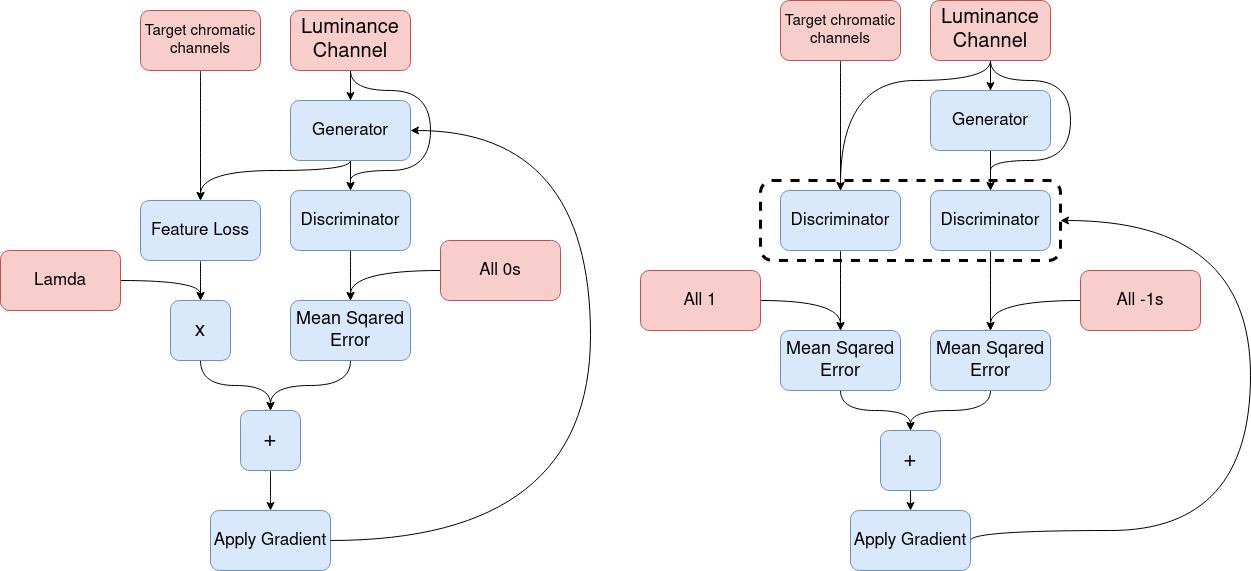

Given an input luminance channel $x$ and the target chromatic channels $y$, a step in the training is defined as:

1. Produce generator ouput $G(x)$ given the input $x$;
2. Produce the the discriminator output $D(x, y)$ given the input $x$ and target $y$;
3. Produce the the discriminator output $D(x, G(x))$ given the input and the output generated by the generator;
4. Calcultate the generator and discriminator loss using the output generated in the previuos steps;
5. Calculate the gradients with respect to the  generator and the discriminator variables;
6. Apply the gradients to the corresponding  optimzer.



(Image adapted from:[Pix2Pix tensorflow turorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=en))

In [ ]:
#define the generator.
generator = define_generator([IMG_SIZE, IMG_SIZE, 1], OUTPUT_CHANNELS, int(log2(IMG_SIZE)))
#define the discrimnator.
discriminator = define_discriminator([IMG_SIZE, IMG_SIZE, 1], [IMG_SIZE, IMG_SIZE, 2])

In [ ]:
#load the the weights of the pretrained generator.
generator.load_weights(f'{BASE_PATH}/pretrained/').assert_consumed()

In [ ]:
#Define a summary writer for tensor board in order to monitor the
#the losses.
import datetime
log_dir="logs/"
 
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
"""
Make a training step given a batch on inputs and targets.
"""
@tf.function
def train_step(input, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #Produce the generator output given the input.
    gen_output = generator(input)

    #Produce the discriminator output given the input and the target.
    disc_real_output = discriminator([input, target])
    #Produce the discriminator output given the input and the generator output..
    disc_generated_output = discriminator([input, gen_output])

    #Calculate the generator loss.
    gen_total_loss, gen_gan_loss, f_loss = generator_loss(disc_generated_output, input, gen_output, target)
    #Calculate the discriminator loss.
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
  
  #Calculate the gradients with respect to the generator variables.
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  #Calculate the gradients with respect to the discriminator variables.
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
  
  #Apply the gradient to the generator optimizer.
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  #Apply the gradient to the  discriminatoroptimizer.
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
 
  #Log the losses in tensor board.
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_f_loss', f_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
#Define a checkpoint-manager in order to save the model weights during the training so that after the
#training the model that yielded the best result can be restored.
checkpoints = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 current_epoch=tf.Variable(0))
manager = tf.train.CheckpointManager(checkpoints, f'{BASE_PATH}/checkpoints', max_to_keep=8)

The training loop:
 
* Reads the training dataset in chunk of batch size and for each chunk call do a trainin step;
* After every epoch generates a plot with the colorization produced by the generator on the validation set;
* After 10 epochs save the model after every epoch.




In [ ]:
"""
Define the trainin loop.
"""
def fit(train_ds, epochs):
  #restore the model saved in in the latest chekpoint.
  checkpoints.restore(manager.latest_checkpoint)

  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  #retrieve the current epochs.
  current_epoch = int(checkpoints.current_epoch)

  #define the progress bar layout.
  widgets=[
    progressbar.Bar(marker='=', left='[', right=']'),
    progressbar.widgets.SimpleProgress(),
    ' - ', progressbar.Timer(), '',
    '-', progressbar.AdaptiveETA(), ''
  ]
  #retrieve the number of batches.
  iters = train_ds.cardinality().numpy()

  for epoch in range(current_epoch, epochs):
    
    print(f'Epoch: {epoch + 1}')
    # Train
    with progressbar.ProgressBar(max_value=iters, widgets=widgets) as pbar:
      for n, (input_image, target, _) in train_ds.enumerate():
        #do a training step.
        train_step(input_image, target, epoch)
        #update the progressabar.
        pbar.update(n.numpy())
    
    #generate a plot with the generator colorization on the validation set.
    path = f'{BASE_PATH}/samples/sample_{epoch + 1}.jpg'
    generate_images(val_dataset, generator , path);

    #increas the current epoch variable in the checkpoint-manager.
    checkpoints.current_epoch.assign_add(1)
    #save (checkpoint) the model after 10 epochs.
    if epoch >= 10:
      manager.save()
    #clear the output of the cell.
    clear_output()

In [ ]:
#load the tensor board.
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
#start training.
fit(train_dataset, EPOCHS)

After the training restore the weights of the generator that produced the best results and save its architecture and weights so that it can be created on the fly.

In [ ]:
BEST_MODEL = 21
checkpoints.restore(f'{BASE_PATH}/checkpoints/ckpt-{BEST_MODEL}')
generator.save(f'{BASE_PATH}/Best model/', include_optimizer=False)

# Test

Load the model and generate coloriziation of the images in the test set.

In [ ]:
#load the generator.
generator = tf.keras.models.load_model(f'{BASE_PATH}/Best model/')

In [ ]:
#download the test dataset.
shutil.copy(f'{BASE_PATH}/Test.zip', ".")
!unzip -q Test.zip
!rm Test.zip

In [ ]:
#create the test dataset input pipeline.
test_paths = tf.data.Dataset.list_files('/content/Test/*.jpg', shuffle=False)
test_dataset = test_paths.map(load_image_test, deterministic=True)\
                          .batch(BATCH_SIZE)\
                          .prefetch(AUTOTUNE)

#generate the colorization of the images in the training dataset.
for Ls, _, file_paths in test_dataset:

  fake_ABs = generator.predict(Ls)

  fake_LABs = tf.concat([Ls, fake_ABs], axis=-1)
  fake_LABs = denormalise(fake_LABs)
  fake_RGBs = convert2rgb(fake_LABs)

  for (fake, file_path) in zip(fake_RGBs, file_paths):
    fake_img = tf.image.convert_image_dtype(fake, dtype=tf.uint8)
    img = tf.image.encode_jpeg(fake_img)

    filename = os.path.basename(file_path.numpy())
    save_path= f'/content/drive/My Drive/VCS Project/examples/{filename.decode("utf-8")}'
    tf.io.write_file(save_path, img)

In [ ]:
drive.flush_and_unmount()